# **Food-101 Image Classification**

## **Installation and import of libraries**

In [1]:
pip install mlflow 


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install mlflow dagshub

In [3]:
pip install dagshub


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install great-expectations


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
## Import all libraries needed
import os
import ast
import shutil
import urllib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import mlflow
import mlflow.pytorch
import dagshub
import great_expectations as gx
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from great_expectations.dataset import PandasDataset
from tqdm import tqdm
from typing import Tuple, Dict, Any, List
from PIL import Image
from typing import Tuple, List
from matplotlib.pyplot import imshow

torch.set_grad_enabled(True)
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
dagshub.init("taed2-Food_Classification", "violeta51", mlflow=True)

mlflow.set_tracking_uri('https://dagshub.com/violeta51/taed2-Food_Classification.mlflow')
mlflow.set_experiment(experiment_name="REPORT INICIAL")

Repository initialized!

<Experiment: artifact_location='mlflow-artifacts:/62f4f6b488564b148a8d5dcc870cb0e6', creation_time=1696057452443, experiment_id='2', last_update_time=1696057452443, lifecycle_stage='active', name='REPORT INICIAL', tags={}>

## **Initialization**

Let's set the working enviroment.

In [3]:
# set a seed for garantee the replication once we finish get the model

seed = 7767
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

Since the model is fairly complex, training it in the GPU will save us time.

In [4]:
# Let's define some hyper-parameters

hparams = {
    'log_interval': 200,
    'epochs' : 20,
    'batch_size' : 64,
}

mlflow.log_param("log_interval", hparams["log_interval"])
mlflow.log_param("epochs", hparams["epochs"])
mlflow.log_param("batch_size", hparams["batch_size"])

64

## **Load the Data**
Since the training data are off-line, we need to load them.

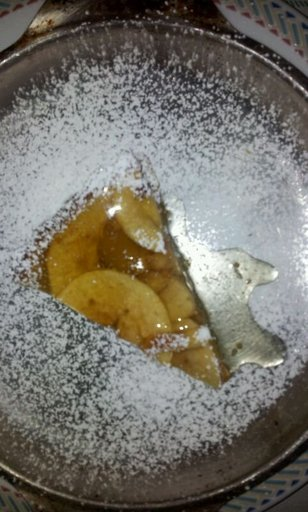

In [5]:
## Open an image

Image.open('/Users/alexandragonzalezalvarez/Desktop/external/apple_pie/1005649.jpg')

In [6]:
## img dir: directory containing the images
## annotations file: file containing the labels

## the following code is a modified version of 
## the code extracted from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self): # returns the number of samples in our dataset.
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        """if len(img_path)< 6:
            print(img_path)"""
            
        image = read_image(img_path)

        to_pil = transforms.ToPILImage()
        image = to_pil(image)
        
        width, height = image.size
        
        if width < 224 or height < 224:
            scale_factor = 512 / max(width, height)
    
        # calculate the new dimensions
            new_width = int(width * scale_factor)
            new_height = int(height * scale_factor)

            image = image.resize((new_height, new_width))
        
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [7]:
# define the composed transformation for training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(),])

In [8]:
## read the folders and load them in a specific class structure

first = False
first_first = True

# transform the target 'words' into numerical values, this dictionary will associate these two values
dictionary = {} 
idx = 0

for dirname, _, filenames in os.walk('/Users/alexandragonzalezalvarez/Desktop/external'):

    if first == True:
        label = dirname[len('/kaggle/input/data-food/external/'):]
        columns = ['file', 'label']
        target = pd.DataFrame(columns=columns)
        
        for filename in filenames:
            target.loc[len(target)] = [filename, idx]
        
        dictionary[idx] =  label
        sub_dataset = CustomImageDataset(target, dirname, transform = train_transforms)
        
        if first_first == True:
            train_data = sub_dataset
            first_first = False
        else:
            train_data = ConcatDataset([train_data, sub_dataset])
        
        idx = idx + 1
        
    first = True     

In [9]:
# show a sample
train_data[2]

(tensor([[[0.8902, 0.8902, 0.8941,  ..., 0.7647, 0.7686, 0.7608],
          [0.8941, 0.8980, 0.8980,  ..., 0.7569, 0.7529, 0.7529],
          [0.8980, 0.9020, 0.8980,  ..., 0.7529, 0.7529, 0.7490],
          ...,
          [0.7451, 0.7216, 0.6784,  ..., 0.6863, 0.6824, 0.6863],
          [0.7412, 0.7412, 0.6941,  ..., 0.6706, 0.6745, 0.6784],
          [0.7176, 0.7137, 0.6941,  ..., 0.6471, 0.6667, 0.6824]],
 
         [[0.8980, 0.8980, 0.9020,  ..., 0.9490, 0.9412, 0.9412],
          [0.9020, 0.9059, 0.9059,  ..., 0.9412, 0.9333, 0.9333],
          [0.9059, 0.9059, 0.9020,  ..., 0.9333, 0.9333, 0.9294],
          ...,
          [0.6784, 0.6549, 0.6118,  ..., 0.7176, 0.7137, 0.7255],
          [0.6745, 0.6745, 0.6275,  ..., 0.7020, 0.7059, 0.7137],
          [0.6510, 0.6471, 0.6275,  ..., 0.6824, 0.7020, 0.7137]],
 
         [[0.8471, 0.8471, 0.8588,  ..., 0.9922, 0.9961, 0.9922],
          [0.8471, 0.8549, 0.8549,  ..., 0.9882, 0.9922, 0.9922],
          [0.8431, 0.8510, 0.8471,  ...,

In [10]:
# split into training and validation set
train_subset, val_subset = torch.utils.data.random_split(train_data, [20000, 10000], generator=torch.Generator().manual_seed(7767))

In [11]:
val_subset[14]

(tensor([[[0.7686, 0.7333, 0.6588,  ..., 0.8549, 0.8549, 0.8549],
          [0.7569, 0.7137, 0.6118,  ..., 0.8549, 0.8549, 0.8588],
          [0.7176, 0.6510, 0.4980,  ..., 0.8588, 0.8588, 0.8588],
          ...,
          [0.3647, 0.2784, 0.2392,  ..., 0.8980, 0.8706, 0.8353],
          [0.3216, 0.2980, 0.2667,  ..., 0.8235, 0.8392, 0.8706],
          [0.3216, 0.3294, 0.3098,  ..., 0.7961, 0.8471, 0.8863]],
 
         [[0.3216, 0.3333, 0.3333,  ..., 0.8078, 0.8078, 0.8078],
          [0.3451, 0.3490, 0.3216,  ..., 0.8078, 0.8078, 0.8118],
          [0.3333, 0.3294, 0.2549,  ..., 0.8118, 0.8118, 0.8118],
          ...,
          [0.4784, 0.3922, 0.3490,  ..., 0.8431, 0.8196, 0.7922],
          [0.4353, 0.4118, 0.3765,  ..., 0.7686, 0.7882, 0.8235],
          [0.4314, 0.4392, 0.4196,  ..., 0.7451, 0.7961, 0.8353]],
 
         [[0.1176, 0.1529, 0.1882,  ..., 0.7216, 0.7216, 0.7216],
          [0.1490, 0.1922, 0.2078,  ..., 0.7216, 0.7216, 0.7255],
          [0.1608, 0.1882, 0.1608,  ...,

### Data Loader 
Once the data are loaded in the workspace, we can prepare the data to feed them into the model.

In [12]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(
    train_subset, 
    batch_size=hparams["batch_size"], 
    shuffle=True,
    num_workers=1, 
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=hparams["batch_size"],
    shuffle=False, 
    num_workers=1,
)

## Create pandas DataFrame from Tensor

In [ ]:
# Initialize an empty DataFrame.
df = pd.DataFrame(columns=['size_dim1', 'size_dim2', 'size_dim3', 'min_colour_range', 'max_colour_range', 'type'])  

# Iterate through all tensors (images) in train_data and add size and range to the DataFrame
for i in tqdm(range(len(train_data)), desc="Processing"): 
    size = list(map(float, train_data[i][0].size()))  # Convert size to a list of floats.
    
    # Dynamic range of the colours in the image.
    min_colour_range = float(torch.min(train_data[i][0]))
    max_colour_range = float(torch.max(train_data[i][0]))

    data_type = train_data[i][0].dtype
    
    data_type = train_data[i][0].dtype
    all_elements_float32 = (data_type == torch.float32)  # Check if all elements are of type torch.float32 

    df = pd.concat([df, pd.DataFrame({'size_dim1': [size[0]], 'size_dim2': [size[1]], 'size_dim3': [size[2]], 'min_colour_range': [min_colour_range], 'max_colour_range': [max_colour_range], 'type_torch.float32': [all_elements_float32]})], ignore_index=True)

# Display the resulting DataFrame
print(df)

In [46]:
# unique values in the 'size_dim2' column
print(df['size_dim1'].value_counts())

size_dim1
3.0    29999
1.0        1
Name: count, dtype: int64


In [48]:
print(df['size_dim2'].value_counts())

size_dim2
224.0    30000
Name: count, dtype: int64


In [49]:
print(df['size_dim3'].value_counts())

size_dim3
224.0    30000
Name: count, dtype: int64


In [50]:
# size of the dataset
print(df.shape)

(30000, 6)


In [51]:
# get the index of the rows with size_dim1 = 1
indexNames = df[df['size_dim1'] == 1].index
print(indexNames)

# delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

Index([23316], dtype='int64')


In [52]:
# size of the dataset
print(df.shape)

(29999, 6)


In [53]:
df.to_csv('x_data_information.csv', index=False)

In [54]:
# Initialize an empty DataFrame.
y_df = pd.DataFrame(columns=['label_id'])  

# Iterate through all tensors (images) in train_data and add size and range to the DataFrame
for i in tqdm(range(len(train_data)), desc="Processing"): 
    label_id = train_data[i][1]

    y_df = pd.concat([y_df, pd.DataFrame({'label_id': [label_id]})], ignore_index=True)

# Display the resulting DataFrame
print(y_df)

Processing: 100%|██████████| 30000/30000 [02:14<00:00, 222.26it/s]

      label_type label_id
0          int64        0
1          int64        0
2          int64        0
3          int64        0
4          int64        0
...          ...      ...
29995      int64       29
29996      int64       29
29997      int64       29
29998      int64       29
29999      int64       29

[30000 rows x 2 columns]


In [55]:
# delete these row indexes from dataFrame
y_df.drop(indexNames , inplace=True)

In [57]:
y_df.to_csv('y_data_information.csv', index=False)